In [1]:
from cdl_helper import read_in_all_matches

df = read_in_all_matches()
df.sample(4)

,gameMap,gameMode,id,programId,firstName,lastName,alias,headshot,socialNetworkHandles,averageSpeed,...,matchGameResult.winnerTeamId,matchGameResult.loserTeamId,homeTeamGamesWon,awayTeamGamesWon,winnerTeamId,loserTeamId,event,setting,totalHeadshots,totalTiersCaptured
17,El Asilo,CDL Control,39,2,Preston,Greiner,Priestahh,https://www.callofduty.com/content/dam/activis...,"[{'socialNetworkType': 'TWITTER', 'handle': 'h...",202.730118,...,17.0,13.0,3,0,17,13,M3Qual,online,NaN,NaN
3,Breenbergh Hotel,CDL Hardpoint,70,2,Sam,Larew,Octane,https://www.callofduty.com/content/dam/activis...,"[{'socialNetworkType': 'TWITTER', 'handle': 't...",161.488098,...,69.0,12.0,0,3,69,12,M2Event,lan,NaN,NaN
1,Al Bagra Fortress,CDL Hardpoint,38,2,Kenneth,Williams,Kenny,https://www.callofduty.com/content/dam/activis...,"[{'socialNetworkType': 'TWITTER', 'handle': 'h...",167.725174,...,69.0,13.0,3,1,13,69,M2Qual,online,NaN,NaN
7,Al Bagra Fortress,CDL Hardpoint,270,2,Marcus,Reid,Afro,https://www.callofduty.com/content/dam/activis...,[],144.948212,...,10.0,12.0,2,3,12,10,M2Qual,online,NaN,NaN


In [2]:
test = df[df['event']=='M3Event']

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cdl_helper import CDL_PALETTE as pal
pal

{'NY': 'yellow',
 'LV': 'orange',
 'BOS': '#0bf52b',
 'FLA': 'cyan',
 'MIN': 'purple',
 'TOR': '#f40afe',
 'ATL': '#f84c4c',
 'TX': 'green',
 'LAT': 'red',
 'LAG': '#7a0265',
 'SEA': 'blue',
 'LDN': '#800020'}

In [4]:
df['matchDesc'] = [f"{player} vs {op}\n({event})" for player, op, event in zip(df['alias'], df['oppo_abbrev'], df['event'])]
df['matchDesc'][:3]

0    Cellium vs BOS\n(M1Qual)
1    Methodz vs ATL\n(M1Qual)
2       Simp vs BOS\n(M1Qual)
Name: matchDesc, dtype: object

In [5]:
df['mapsPlayed'] = df['homeTeamGamesWon'] + df['awayTeamGamesWon']
df['mapsPlayed'].unique()

array([4, 5, 3, 6], dtype=int64)

<AxesSubplot:xlabel='matchDesc'>

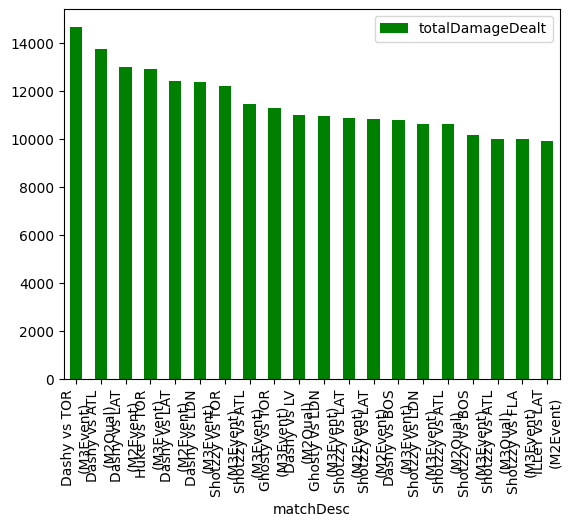

In [6]:
refined = df[['matchDesc', 'abbrev', 'totalDamageDealt', 'matchGame.matchId', 'alias', 'team_id', 'winnerTeamId', 'mapsPlayed']]
damage_df = refined.groupby(['matchDesc', 'abbrev', 'matchGame.matchId', 'alias', 'team_id', 'winnerTeamId', 'mapsPlayed']).sum().reset_index()
tx_dam = damage_df[damage_df['abbrev']=='TX'].sort_values(by='totalDamageDealt', ascending=False).reset_index().drop('index', axis=1)
tx_dam[['matchDesc', 'totalDamageDealt']].iloc[0:20].set_index('matchDesc').plot(kind="bar", color='green')

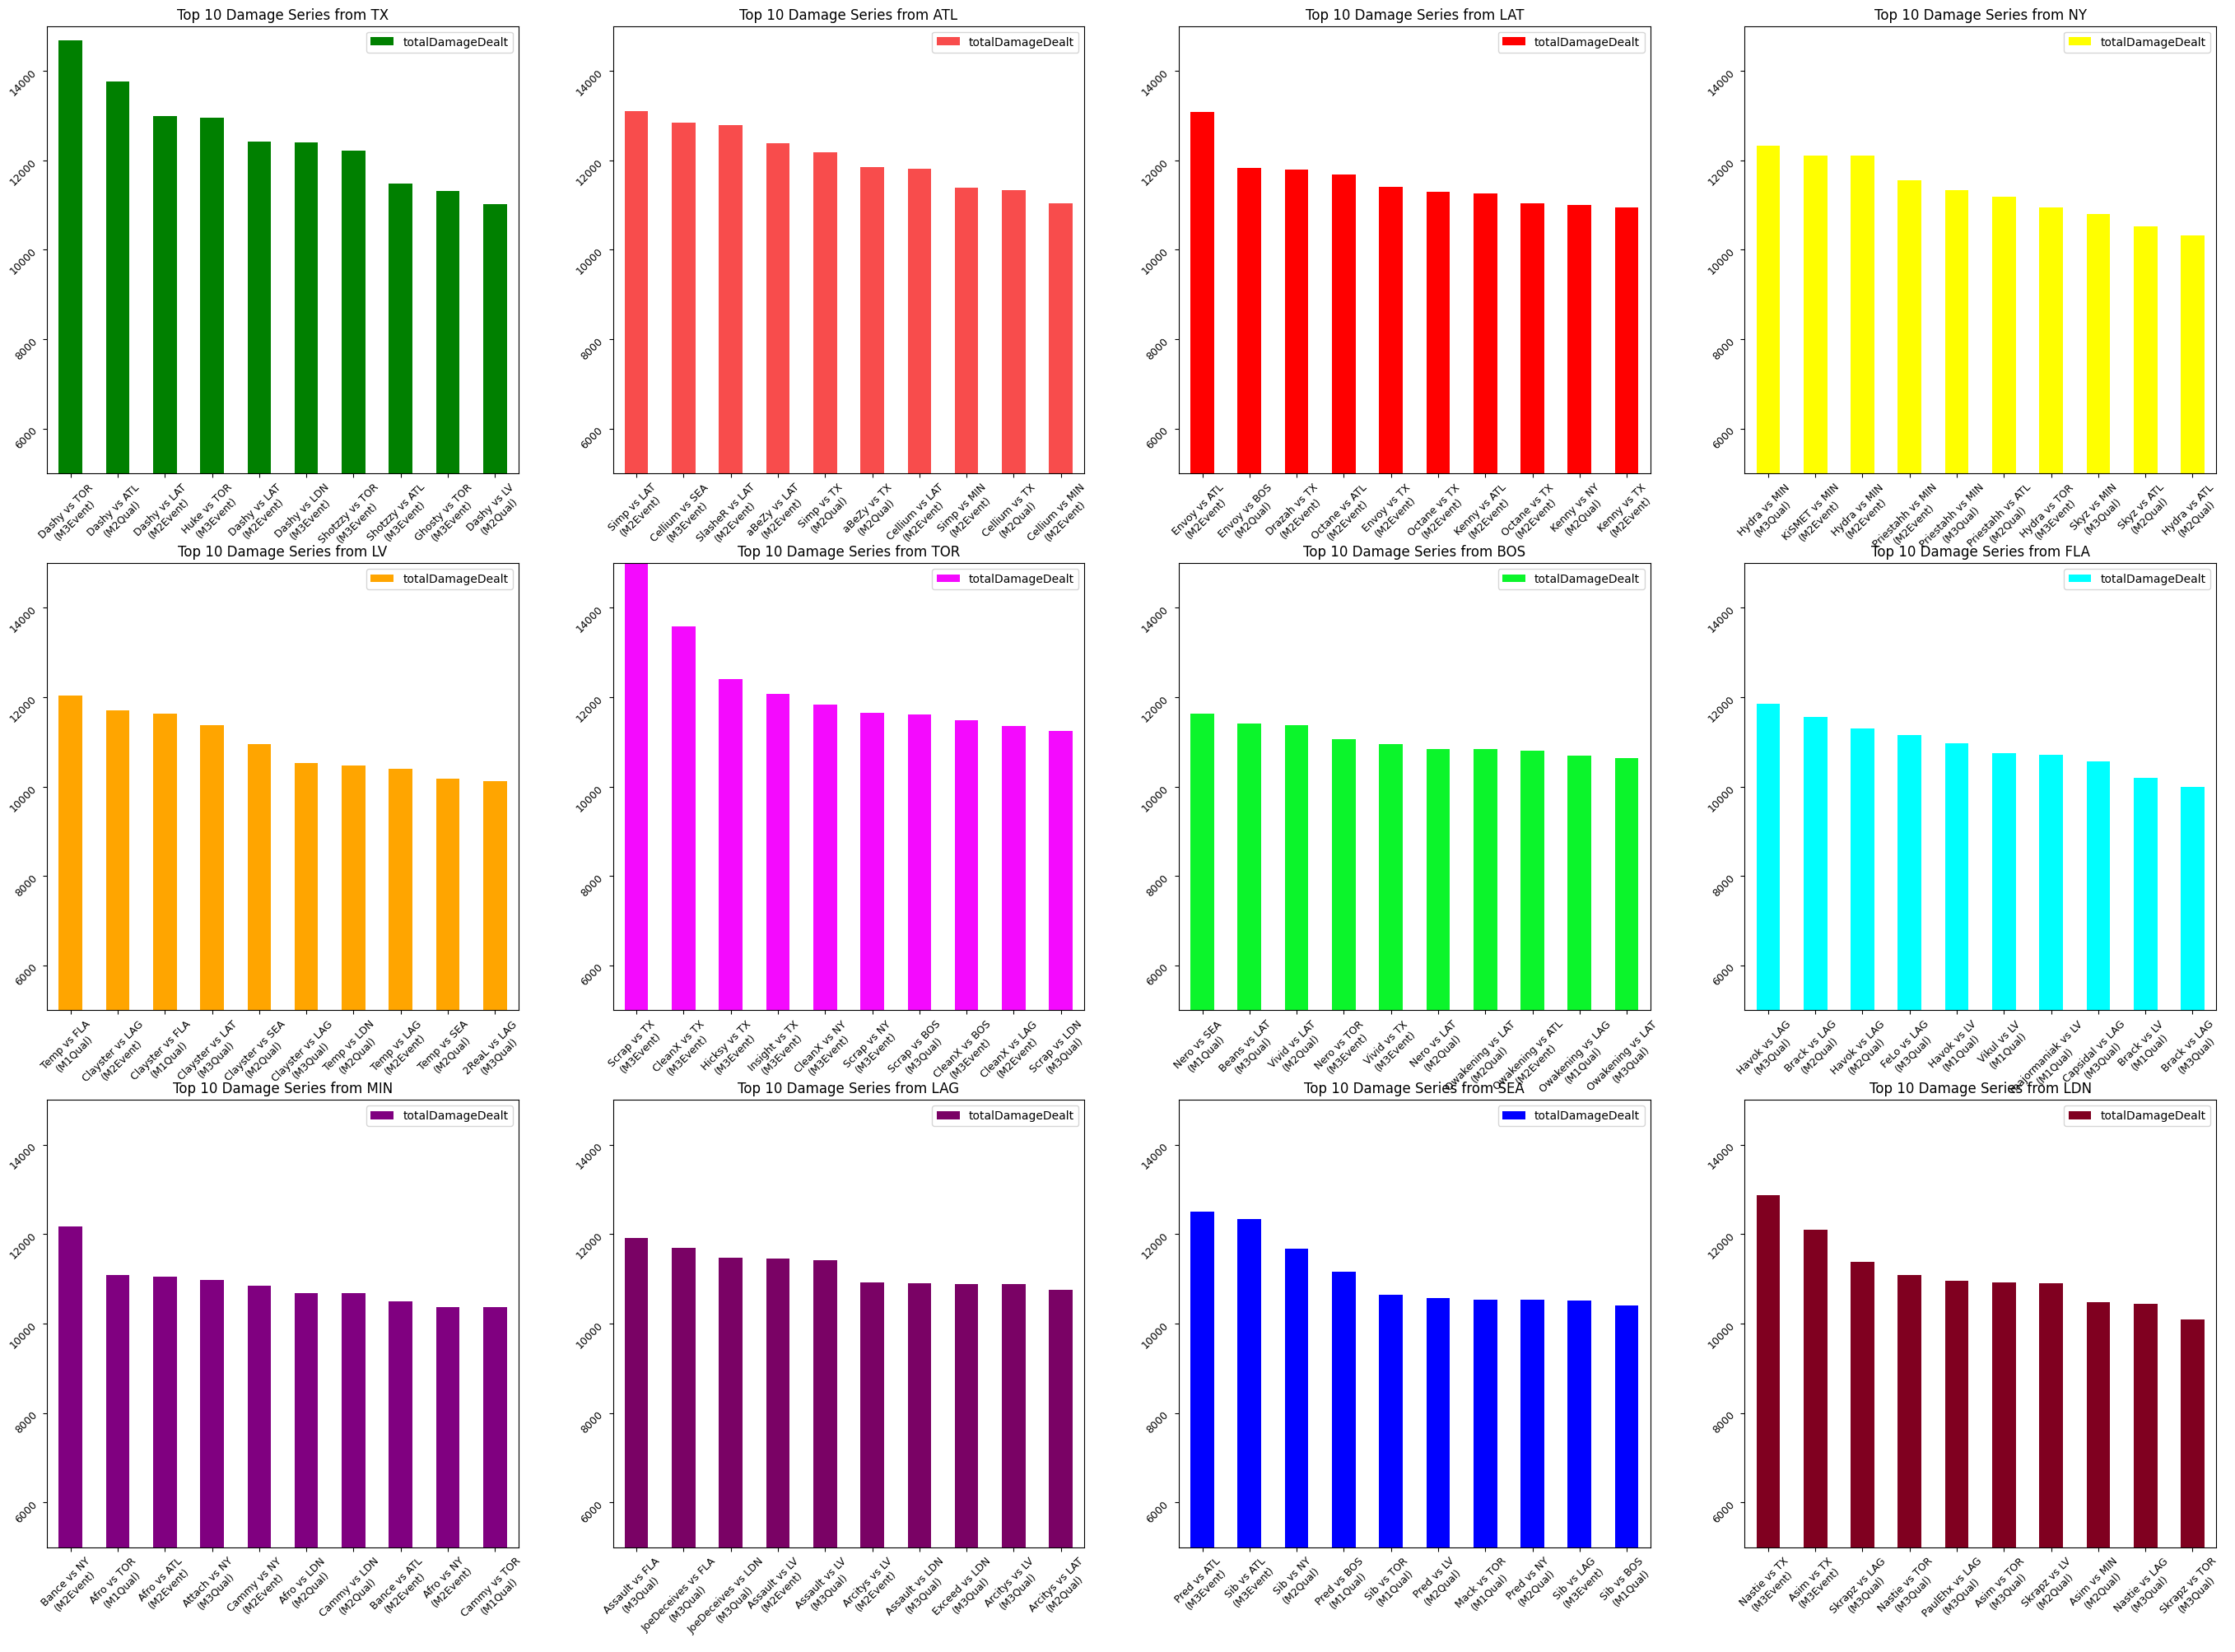

In [7]:

fig = plt.figure(figsize=(34, 24))
axes = [((x for i in range(4)) for i in range(3))] 
axes = fig.subplots(ncols=4, nrows=3)

damage_df = damage_df.sort_values('totalDamageDealt', ascending=False)
teams = (('TX', 'ATL', 'LAT', 'NY'), ('LV', 'TOR', 'BOS', 'FLA'), ('MIN', 'LAG', 'SEA', 'LDN'))
for i in range(len(teams)):
    for j in range(4):
        refined_df = damage_df[damage_df['abbrev']==teams[i][j]]
        refined.sort_values('totalDamageDealt', ascending=False)
        refined_df[['matchDesc', 'totalDamageDealt']].iloc[0:10].set_index('matchDesc').plot(kind='bar', ax=axes[i][j], color=pal[teams[i][j]])
        axes[i][j].set_title(f"Top 10 Damage Series from {teams[i][j]}")
        axes[i][j].tick_params(rotation=45, labelsize=9)
        axes[i][j].set(xlabel=None)
        axes[i][j].set_ylim(5000, 15000)

fig.savefig("top_10_dmg.png")
        



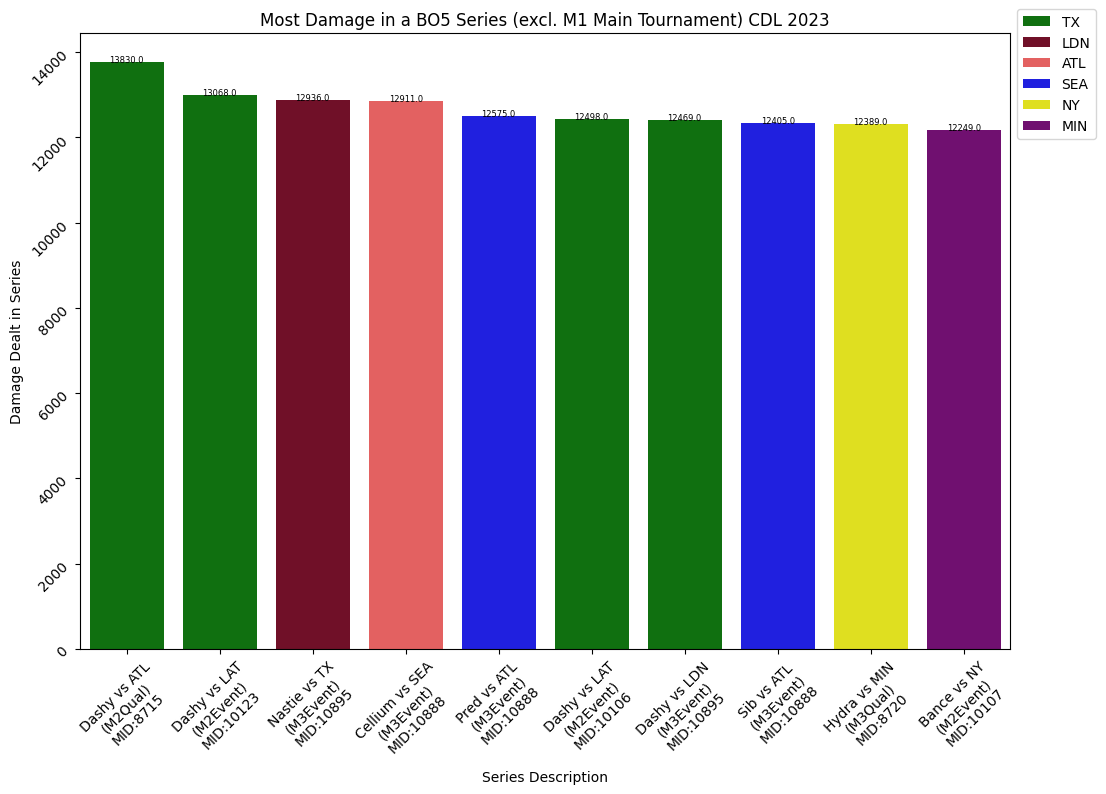

In [8]:
new_fig = plt.figure(figsize=(12, 8))
(ax1) = new_fig.subplots()
sorted_df = damage_df.sort_values('totalDamageDealt', ascending=False)
sorted_df['matchDesc'] = [f"{a}\nMID:{b}" for a, b in zip(sorted_df['matchDesc'], sorted_df['matchGame.matchId'])]
sorted_df = sorted_df[~sorted_df['matchGame.matchId'].isin([10113, 10891])]
sns.barplot(data=sorted_df.iloc[0:10], x='matchDesc', y='totalDamageDealt', hue='abbrev', palette=pal, ax=ax1, dodge=False, errorbar=('ci', 0))
ax1.legend(bbox_to_anchor=(1, 1.05))
ax1.tick_params(rotation=45)
ax1.set_ylabel("Damage Dealt in Series")
ax1.set_xlabel("Series Description")
for x, y in zip(ax1.get_xticks(), sorted_df['totalDamageDealt']):
    ax1.text(x, y, s=y+70, horizontalalignment='center', fontsize=6)

ax1.set_title("Most Damage in a BO5 Series (excl. M1 Main Tournament) CDL 2023");
new_fig.savefig("dmg.png")

Text(8.5, 12200, 'Series Loss')

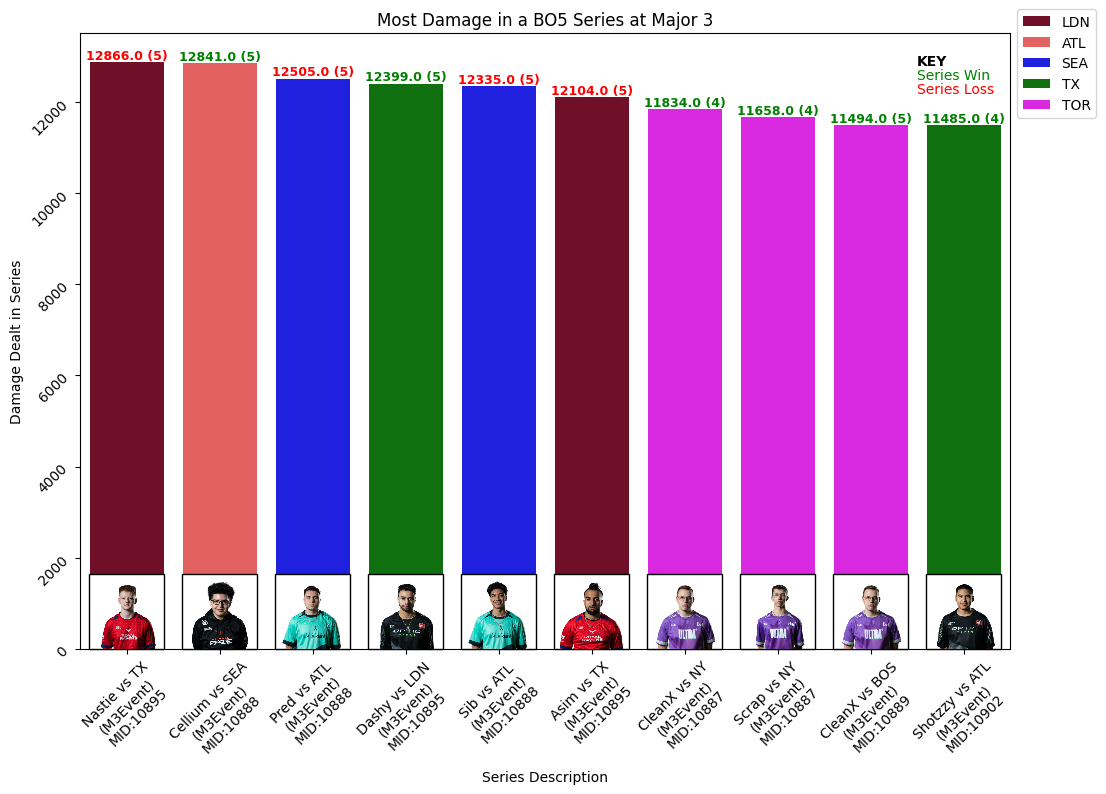

In [9]:
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

damage_df['isMatchWinner'] = ['y' if a == b else 'n' for a, b in zip(damage_df['winnerTeamId'], damage_df['team_id'])]

new_fig = plt.figure(figsize=(12, 8))
(ax1) = new_fig.subplots()
sorted_df = damage_df.sort_values('totalDamageDealt', ascending=False)
m3_event_ids = pd.read_json('../major_ids.json')['major3']['event']
sorted_df = sorted_df[sorted_df['matchGame.matchId'].isin(m3_event_ids)]
sorted_df['matchDesc'] = [f"{a}\nMID:{b}" for a, b in zip(sorted_df['matchDesc'], sorted_df['matchGame.matchId'])]
sorted_df = sorted_df[~sorted_df['matchGame.matchId'].isin([10113, 10891])]
sns.barplot(data=sorted_df.iloc[0:10], x='matchDesc', y='totalDamageDealt', hue='abbrev', palette=pal, ax=ax1, dodge=False, errorbar=('ci', 0))
ax1.legend(bbox_to_anchor=(1, 1.05))
ax1.tick_params(rotation=45)
ax1.set_ylabel("Damage Dealt in Series")
ax1.set_xlabel("Series Description")
for x, y, ali, win, mp in zip(ax1.get_xticks(), sorted_df['totalDamageDealt'], sorted_df['alias'], sorted_df['isMatchWinner'], sorted_df['mapsPlayed']):
    ax1.text(x, y+70, s=f"{str(y)} ({mp})", horizontalalignment='center', fontsize=9, weight="bold", color='green' if win == 'y' else 'red')
    img = image.imread(f"../images/{ali}_headshot.png")
    im_box = OffsetImage(img, zoom=0.09)
    anno_box = AnnotationBbox(im_box, xy=(x, ax1.get_ylim()[0]), frameon=True, pad=0, box_alignment=(0.5, 0.))
    ax1.add_artist(anno_box)

ax1.set_title("Most Damage in a BO5 Series at Major 3");
ax1.text(8.5, 12800, s='KEY', color='black', weight='bold')
ax1.text(8.5, 12500, s='Series Win', color='green')
ax1.text(8.5, 12200, s='Series Loss', color='red')

Text(8.5, 5500, 'Series Loss')

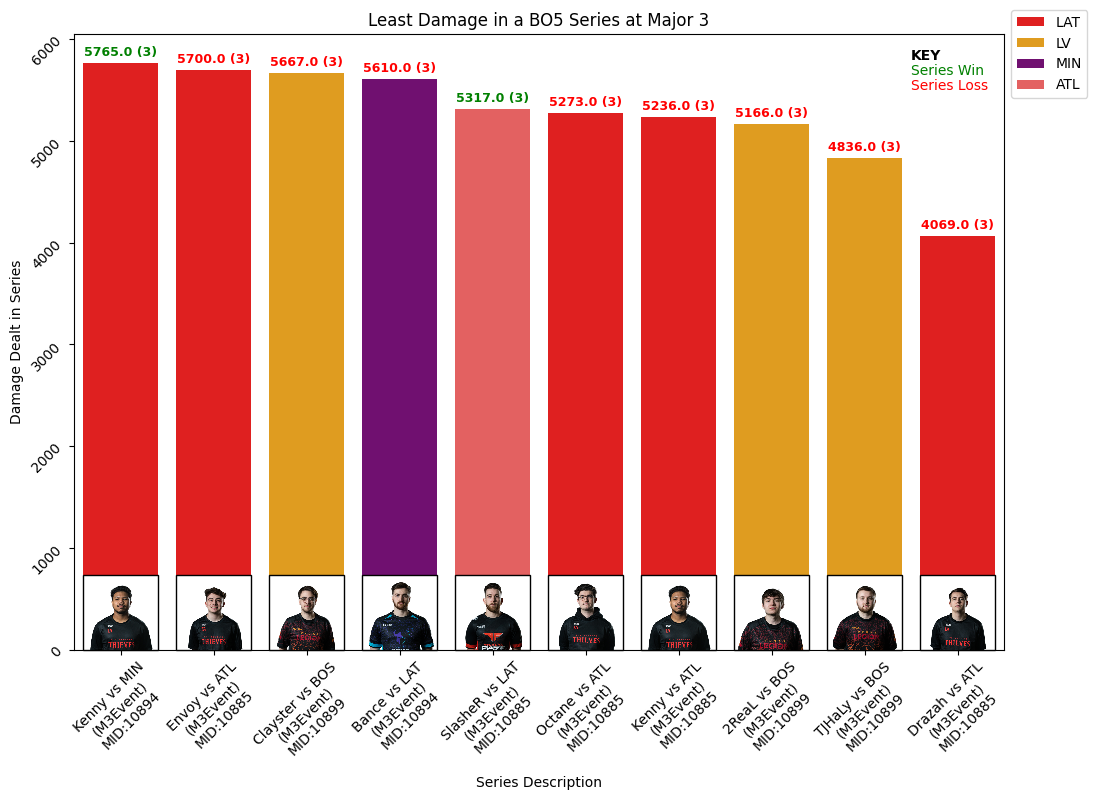

In [11]:
new_fig = plt.figure(figsize=(12, 8))
(ax1) = new_fig.subplots()
sorted_df = damage_df.sort_values('totalDamageDealt', ascending=False)
m3_event_ids = pd.read_json('../major_ids.json')['major3']['event']
sorted_df = sorted_df[sorted_df['matchGame.matchId'].isin(m3_event_ids)]
sorted_df['matchDesc'] = [f"{a}\nMID:{b}" for a, b in zip(sorted_df['matchDesc'], sorted_df['matchGame.matchId'])]
sorted_df = sorted_df[~sorted_df['matchGame.matchId'].isin([10113, 10891])]
sorted_df = sorted_df.iloc[-10:]
sns.barplot(data=sorted_df, x='matchDesc', y='totalDamageDealt', hue='abbrev', palette=pal, ax=ax1, dodge=False, errorbar=('ci', 0))
ax1.legend(bbox_to_anchor=(1, 1.05))
ax1.tick_params(rotation=45)
ax1.set_ylabel("Damage Dealt in Series")
ax1.set_xlabel("Series Description")
for x, y, ali, win, mp in zip(ax1.get_xticks(), sorted_df['totalDamageDealt'], sorted_df['alias'], sorted_df['isMatchWinner'], sorted_df['mapsPlayed']):
    ax1.text(x, y+70, s=f"{str(y)} ({mp})", horizontalalignment='center', fontsize=9, weight="bold", color='green' if win == 'y' else 'red')
    img = image.imread(f"../images/{ali}_headshot.png")
    im_box = OffsetImage(img, zoom=0.09)
    anno_box = AnnotationBbox(im_box, xy=(x, ax1.get_ylim()[0]), frameon=True, pad=0, box_alignment=(0.5, 0.))
    ax1.add_artist(anno_box)

ax1.set_title("Least Damage in a BO5 Series at Major 3");
ax1.text(8.5, 5800, s='KEY', color='black', weight='bold')
ax1.text(8.5, 5650, s='Series Win', color='green')
ax1.text(8.5, 5500, s='Series Loss', color='red')